# Final Project

#### Riju Pant, Andrew ZiYu Wang, Alisa Sumwalt

In [49]:
import os
import pandas as pd
df = pd.read_csv('C:/Users/alisa/Desktop/cancer/data.csv')
print(type(df))
df.head(20)

<class 'pandas.core.frame.DataFrame'>


,id,diagnosis,radius_mean,texture_mean,perimeter_mean,area_mean,smoothness_mean,compactness_mean,concavity_mean,concave points_mean,...,texture_worst,perimeter_worst,area_worst,smoothness_worst,compactness_worst,concavity_worst,concave points_worst,symmetry_worst,fractal_dimension_worst,Unnamed: 32
0,842302,M,17.99,10.38,122.80,1001.0,0.11840,0.27760,0.30010,0.14710,...,17.33,184.60,2019.0,0.1622,0.6656,0.7119,0.26540,0.4601,0.11890,NaN
1,842517,M,20.57,17.77,132.90,1326.0,0.08474,0.07864,0.08690,0.07017,...,23.41,158.80,1956.0,0.1238,0.1866,0.2416,0.18600,0.2750,0.08902,NaN
2,84300903,M,19.69,21.25,130.00,1203.0,0.10960,0.15990,0.19740,0.12790,...,25.53,152.50,1709.0,0.1444,0.4245,0.4504,0.24300,0.3613,0.08758,NaN
3,84348301,M,11.42,20.38,77.58,386.1,0.14250,0.28390,0.24140,0.10520,...,26.50,98.87,567.7,0.2098,0.8663,0.6869,0.25750,0.6638,0.17300,NaN
4,84358402,M,20.29,14.34,135.10,1297.0,0.10030,0.13280,0.19800,0.10430,...,16.67,152.20,1575.0,0.1374,0.2050,0.4000,0.16250,0.2364,0.07678,NaN
5,843786,M,12.45,15.70,82.57,477.1,0.12780,0.17000,0.15780,0.08089,...,23.75,103.40,741.6,0.1791,0.5249,0.5355,0.17410,0.3985,0.12440,NaN
6,844359,M,18.25,19.98,119.60,1040.0,0.09463,0.10900,0.11270,0.07400,...,27.66,153.20,1606.0,0.1442,0.2576,0.3784,0.19320,0.3063,0.08368,NaN
7,84458202,M,13.71,20.83,90.20,577.9,0.11890,0.16450,0.09366,0.05985,...,28.14,110.60,897.0,0.1654,0.3682,0.2678,0.15560,0.3196,0.11510,NaN
8,844981,M,13.00,21.82,87.50,519.8,0.12730,0.19320,0.18590,0.09353,...,30.73,106.20,739.3,0.1703,0.5401,0.5390,0.20600,0.4378,0.10720,NaN
9,84501001,M,12.46,24.04,83.97,475.9,0.11860,0.23960,0.22730,0.08543,...,40.68,97.65,711.4,0.1853,1.0580,1.1050,0.22100,0.4366,0.20750,NaN


In [50]:
df.isnull().values.any()
df.isnull().sum()
df = df.drop("Unnamed: 32",axis=1)
df = df.drop("id", axis=1)
df["diagnosis"] = df["diagnosis"].map({'M':1,'B':0})

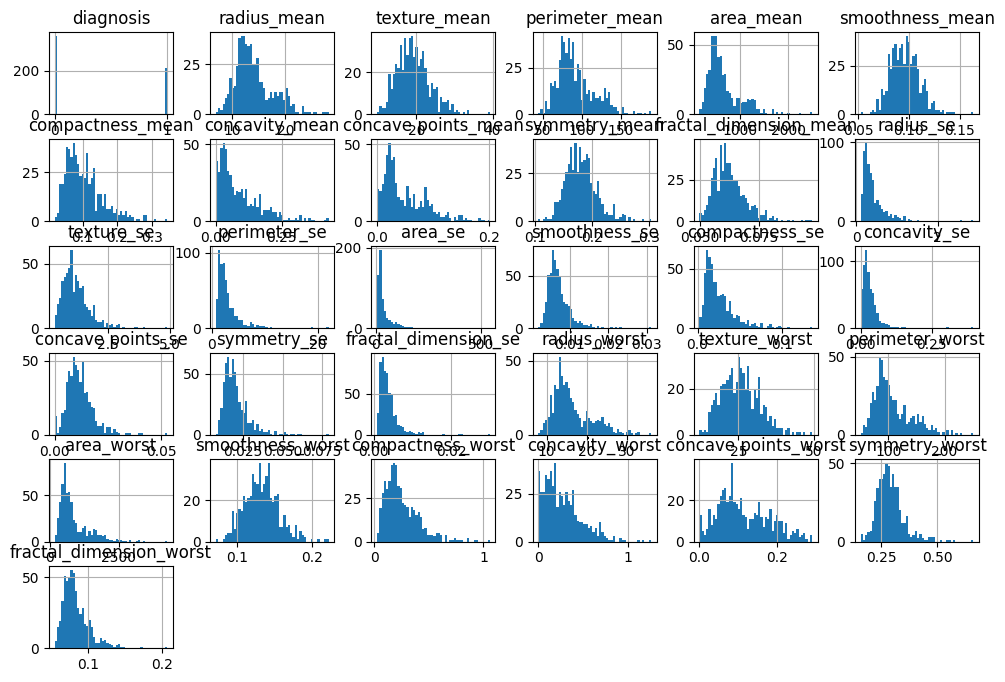

In [51]:
import matplotlib.pyplot as plt

df.hist(bins=50, figsize=(12, 8))
plt.show()

In [52]:
ftMean = df.columns[1:11]
ftMean = list(ftMean)
ftSE = df.columns[11:21]
ftSE = list(ftSE)
ftWorst = df.columns[21:31]
ftWorst = list(ftWorst)
print(ftMean)
print(ftSE)
print(ftWorst)

['radius_mean', 'texture_mean', 'perimeter_mean', 'area_mean', 'smoothness_mean', 'compactness_mean', 'concavity_mean', 'concave points_mean', 'symmetry_mean', 'fractal_dimension_mean']
['radius_se', 'texture_se', 'perimeter_se', 'area_se', 'smoothness_se', 'compactness_se', 'concavity_se', 'concave points_se', 'symmetry_se', 'fractal_dimension_se']
['radius_worst', 'texture_worst', 'perimeter_worst', 'area_worst', 'smoothness_worst', 'compactness_worst', 'concavity_worst', 'concave points_worst', 'symmetry_worst', 'fractal_dimension_worst']


In [53]:
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, confusion_matrix
import numpy as np 

X = df[['radius_mean', 'texture_mean', 'perimeter_mean', 'area_mean', 'smoothness_mean', 'compactness_mean', 'concavity_mean', 'concave points_mean', 'symmetry_mean', 'fractal_dimension_mean']]
y = df[['diagnosis']]
x_train,x_test,y_train,y_test = train_test_split(X,y,test_size=0.3,random_state=42)
log = LogisticRegression(random_state=42)
log.fit(x_train,y_train)






c:\Users\alisa\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\utils\validation.py:1408: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
c:\Users\alisa\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\linear_model\_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


LogisticRegression(random_state=42)

In [54]:
from sklearn.metrics import log_loss
predictions1 = log.predict(x_test)
print(predictions1)
proba = log.predict_proba(x_test)
print("The log-loss is:", log_loss(y_test, proba))
accuracy1 = accuracy_score(y_test, predictions1)
print("accuracy is:", accuracy1)

[0 1 1 0 0 1 1 1 0 0 0 1 0 1 0 1 0 0 0 1 0 0 1 0 0 0 0 0 0 1 0 0 0 0 0 0 1
 0 1 1 0 1 0 0 0 0 0 0 0 0 1 1 0 0 0 0 0 1 0 0 0 1 1 1 0 0 1 1 0 0 1 1 0 1
 0 0 0 0 0 0 1 0 0 1 1 1 1 1 0 0 0 0 0 0 0 0 1 1 0 1 1 0 1 1 0 0 0 1 0 0 1
 0 1 1 0 1 0 0 0 1 1 0 0 1 0 1 1 0 0 1 1 1 0 0 0 1 0 0 0 0 0 1 0 0 0 0 1 1
 1 0 1 0 0 0 0 1 1 0 0 0 0 0 0 0 1 0 0 1 0 1 0]
The log-loss is: 0.162725265111666
accuracy is: 0.935672514619883


In [55]:
X = df[['radius_se', 'texture_se', 'perimeter_se', 'area_se', 'smoothness_se', 'compactness_se', 'concavity_se', 'concave points_se', 'symmetry_se', 'fractal_dimension_se']]
y = df[['diagnosis']]
x_train,x_test,y_train,y_test = train_test_split(X,y,test_size=0.3,random_state=42)
log = LogisticRegression(random_state=42)
log.fit(x_train,y_train)

predictions2 = log.predict(x_test)
print(predictions2)
proba = log.predict_proba(x_test)
print("The log-loss is:", log_loss(y_test, proba))
accuracy2  = accuracy_score(y_test, predictions2)
print("accuracy is:", accuracy2)


[0 1 1 0 0 1 1 1 0 0 0 1 0 1 0 1 0 0 0 1 0 0 1 0 0 0 0 0 0 1 0 0 0 0 0 0 1
 0 1 0 0 1 0 0 1 0 0 0 0 0 1 1 0 0 0 0 0 1 0 0 0 1 1 0 0 0 1 1 0 0 1 1 0 0
 0 0 0 1 0 0 1 0 0 1 1 1 0 1 0 0 0 0 1 0 0 0 1 1 0 1 1 0 1 1 0 0 0 1 0 0 1
 0 0 1 0 1 0 0 0 0 1 0 0 1 0 1 1 0 0 1 1 0 0 0 0 1 0 0 1 0 0 1 0 0 0 0 1 1
 0 0 0 0 0 0 0 1 1 0 0 0 0 0 0 0 1 0 0 0 0 1 0]
The log-loss is: 0.2459688363706901
accuracy is: 0.9122807017543859


c:\Users\alisa\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\utils\validation.py:1408: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


In [56]:
X = df[['radius_worst', 'texture_worst', 'perimeter_worst', 'area_worst', 'smoothness_worst', 'compactness_worst', 'concavity_worst', 'concave points_worst', 'symmetry_worst', 'fractal_dimension_worst']]
y = df[['diagnosis']]
x_train,x_test,y_train,y_test = train_test_split(X,y,test_size=0.3,random_state=42)
log = LogisticRegression(random_state=42)
log.fit(x_train,y_train)

predictions3 = log.predict(x_test)
print(predictions3)
proba = log.predict_proba(x_test)
print("The log-loss is:", log_loss(y_test, proba))
accuracy3 = accuracy_score(y_test, predictions3)
print("accuracy is:", accuracy3)

[0 1 1 0 0 1 1 1 0 0 0 1 0 1 0 1 0 0 0 1 0 0 1 0 0 0 0 0 0 1 0 0 0 0 0 0 1
 0 1 0 0 1 0 0 0 0 0 0 0 0 1 1 0 0 0 0 0 1 0 0 0 1 1 0 0 0 1 1 0 0 1 1 0 1
 0 0 0 0 0 0 1 0 0 1 1 1 1 1 0 0 0 0 0 0 0 0 1 1 0 1 1 0 1 1 0 0 0 1 0 0 1
 0 1 1 0 1 0 0 0 1 0 0 0 1 0 1 1 0 0 1 1 1 0 0 0 1 0 0 0 1 0 1 0 0 1 0 1 1
 1 0 1 0 0 0 0 1 1 0 0 0 0 0 0 0 1 0 0 0 0 1 0]
The log-loss is: 0.09190146003005702
accuracy is: 0.9707602339181286


c:\Users\alisa\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\utils\validation.py:1408: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
c:\Users\alisa\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\linear_model\_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


In [57]:
X = df[['radius_worst', 'texture_worst', 'smoothness_worst', 'compactness_worst', 'concavity_worst', 'concave points_worst', 'symmetry_worst', 'fractal_dimension_worst']]
y = df[['diagnosis']]
x_train,x_test,y_train,y_test = train_test_split(X,y,test_size=0.3,random_state=42)
log = LogisticRegression(random_state=42)
log.fit(x_train,y_train)

predictions3 = log.predict(x_test)
print(predictions3)
proba = log.predict_proba(x_test)
print("The log-loss is:", log_loss(y_test, proba))
accuracy3 = accuracy_score(y_test, predictions3)
print("accuracy is:", accuracy3)

[0 1 1 0 0 1 1 1 0 0 0 1 0 1 0 1 0 0 0 1 0 0 1 0 0 0 0 0 0 1 0 0 0 0 0 0 1
 0 1 0 0 1 0 0 0 0 0 0 0 0 1 1 0 0 0 0 0 1 0 0 0 1 1 0 0 0 1 1 0 0 1 1 0 1
 0 0 0 0 0 0 1 0 1 1 1 1 1 1 0 0 0 0 0 0 0 0 1 1 0 1 1 0 1 1 0 0 0 1 0 0 1
 0 1 1 0 1 0 0 0 1 0 0 0 1 0 1 1 0 0 1 1 1 0 0 0 1 0 0 0 1 0 1 0 0 1 0 1 1
 1 0 1 0 0 0 0 1 1 0 0 0 0 0 0 0 1 0 0 1 0 1 0]
The log-loss is: 0.08914710465329372
accuracy is: 0.9707602339181286


c:\Users\alisa\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\utils\validation.py:1408: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Intuitive to remove perimeter or area or radius since they are all mathematically related. As you can see the log-loss went down after removing area and perimeter. 